Found 16 rows of 4h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_scale_factor', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
    config_id  power_mw  energy_mwh   scenario  dc_price_scale_factor  \
32         17        15          60  base_case                   1.00   
33         17        15          60   down_10%                   0.90   
34         17        15          60    down_5%                   0.95   
35         17        15          60      up_5%                   1.05   
36         17        15          60     up_10%                   1.10   

    dam_weight    idm_weight  dc_weight  expected_return  portfolio_risk  \
32    0.990302  1.387779e-17   0.009698      2181.048445     1677.562155   
33    0.984332  0.000000e+00   0.015668      2173.240141     1671.843874   
34    0.987258  2.775558e-17   0.012742      2177.260581     1674.718605   
35    0.993471  2.7755

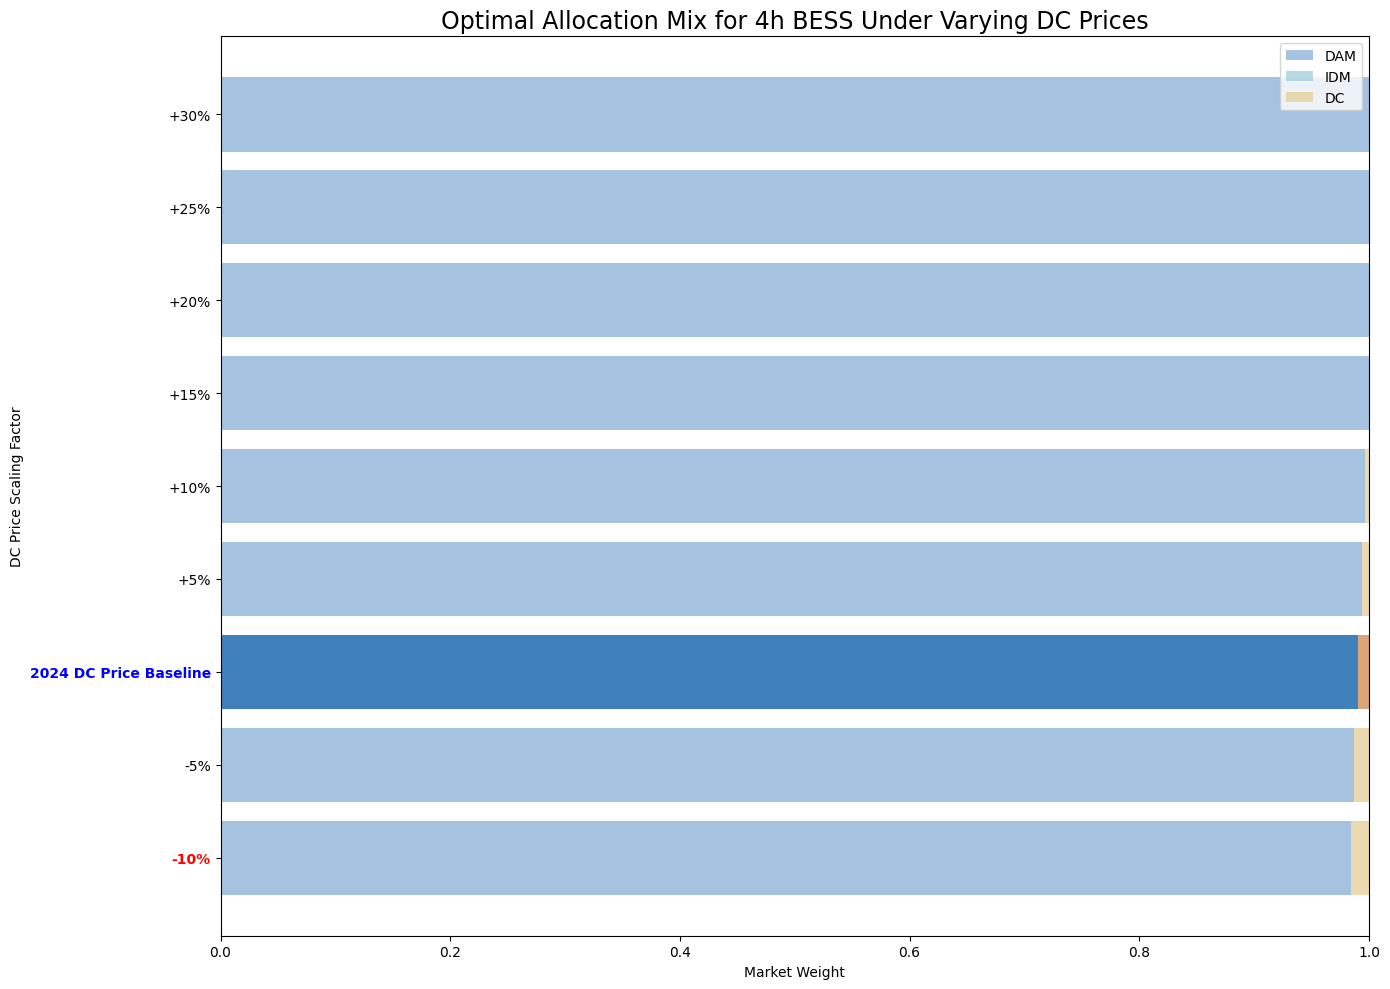

Found 52 rows of 1h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_scale_factor', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
   config_id  power_mw  energy_mwh   scenario  dc_price_scale_factor  \
0          1        10          10  base_case                   1.00   
1          1        10          10   down_30%                   0.70   
2          1        10          10   down_25%                   0.75   
3          1        10          10   down_20%                   0.80   
4          1        10          10   down_15%                   0.85   

     dam_weight    idm_weight  dc_weight  expected_return  portfolio_risk  \
0  2.039985e-01  7.840950e-16   0.796001       726.268385      389.262760   
1  2.303818e-16  2.578638e-01   0.742136       536.369775      357.579630   
2  0.000000e+00  1.610490e-01   0.838951       578.151669      358.608311   
3  0.000000e+00  5.51860

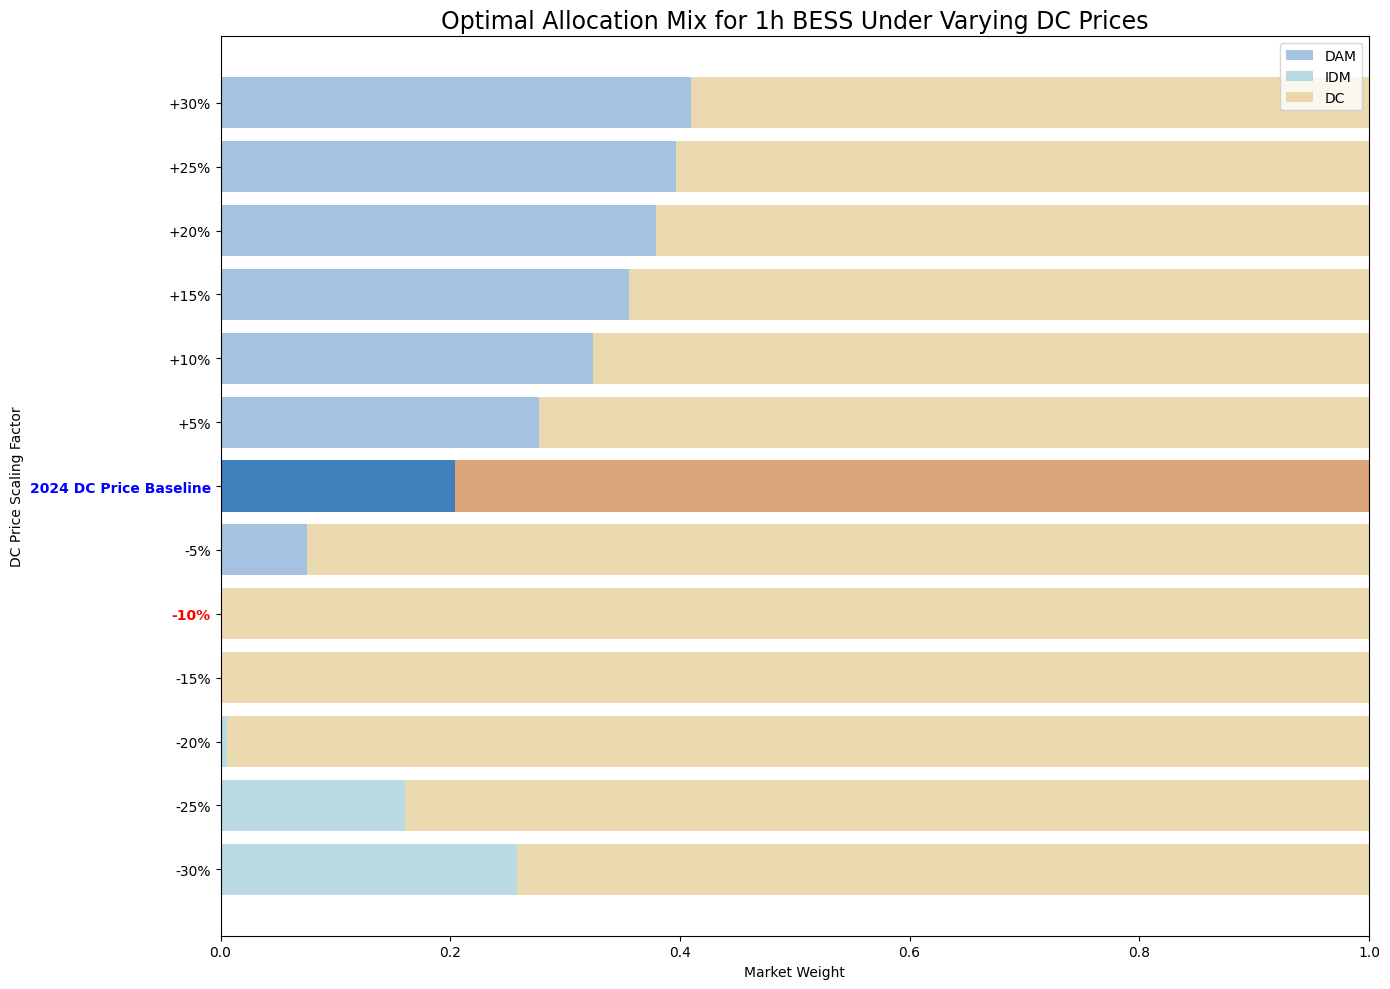

In [13]:
# A=4 1-Hour Battery Analysis (scaling from -30% to +30%)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load 1-hour battery data
df_1h = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_13&15-18_Model Outputs/Fig_13,15,16_data.csv')
df_1h['duration'] = df_1h['energy_mwh'] / df_1h['power_mw']

# Filter for 1-hour batteries only
df_1h = df_1h[df_1h['duration'] == 1.0]

# Check if we have data for 1h batteries
if df_1h.empty:
    print("No 1h battery data found in the dataset")
else:
    print(f"Found {len(df_1h)} rows of 1h battery data")
    print("Available columns:", df_1h.columns.tolist())
    print("Sample of data:")
    print(df_1h.head())

# Get unique scenarios for 1h data
scenarios_1h = df_1h['scenario'].unique()
print("Available scenarios:", scenarios_1h)

# Create summary data for 1h battery
summary_1h = []
for scenario in scenarios_1h:
    scenario_data = df_1h[df_1h['scenario'] == scenario]
    if not scenario_data.empty:
        row = scenario_data.iloc[0]
        summary_1h.append({
            'scenario': scenario,
            'dc_price_scale': row['dc_price_scale_factor'],
            'dam_weight': row['dam_weight'],
            'idm_weight': row['idm_weight'],
            'dc_weight': row['dc_weight']
        })

summary_1h_df = pd.DataFrame(summary_1h)

# Check if we have any data
if summary_1h_df.empty:
    print("No summary data created - check data availability")
else:
    # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
    summary_1h_df = summary_1h_df[(summary_1h_df['dc_price_scale'] >= 0.7) & 
                                  (summary_1h_df['dc_price_scale'] <= 1.3)]
    
    # Create mapping from scale factor to percentage labels for 1h data (-30% to +30%)
    scale_to_label_1h = {
        0.7: '-30%', 0.75: '-25%', 0.8: '-20%', 0.85: '-15%', 
        0.9: '-10%', 0.95: '-5%',
        1.0: '2024 DC Price Baseline',
        1.05: '+5%', 1.1: '+10%', 1.15: '+15%', 1.2: '+20%', 1.25: '+25%', 1.3: '+30%'
    }
    
    # Single horizontal stacked bar chart for 1h battery
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Base colors (full saturation for base case)
    base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
    # Less saturated colors for other scenarios
    light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}
    
    # Sort by DC price scale
    subset_1h = summary_1h_df.sort_values('dc_price_scale')
    y_pos = np.arange(len(subset_1h))
    
    # Create bars with different colors based on scenario
    for i, (idx, row) in enumerate(subset_1h.iterrows()):
        scale = row['dc_price_scale']
        
        # Determine colors based on scenario
        if scale == 1.0:  # Base case
            colors = base_colors
        else:
            colors = light_colors
        
        # Horizontal stacked bars
        ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                color=colors['DAM'], alpha=0.8)
        ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
        ax.barh(i, row['dc_weight'], 
                left=row['dam_weight'] + row['idm_weight'],
                label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
    
    ax.set_ylabel('DC Price Scaling Factor')
    ax.set_xlabel('Market Weight')
    ax.set_title('Optimal Allocation Mix for 1h BESS Under Varying DC Prices', fontsize=17)
    ax.set_yticks(y_pos)
    
    # Create y-tick labels with special formatting
    y_labels = []
    for scale in subset_1h['dc_price_scale']:
        label = scale_to_label_1h[scale]
        y_labels.append(label)
    
    ax.set_yticklabels(y_labels)
    
    # Format specific labels with color and weight
    for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_1h['dc_price_scale'])):
        if scale in [0.9]:  # -10% - highlighting relevant scale for 1h
            tick.set_color('red')
            tick.set_fontweight('bold')
        elif scale == 1.0:  # Base case
            tick.set_color('blue')
            tick.set_fontweight('bold')
    
    ax.legend()
    ax.grid(False)  # Remove grid
    ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
  

Found 52 rows of 1h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_scale_factor', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
   config_id  power_mw  energy_mwh   scenario  dc_price_scale_factor  \
0          1        10          10  base_case                   1.00   
1          1        10          10   down_30%                   0.70   
2          1        10          10   down_25%                   0.75   
3          1        10          10   down_20%                   0.80   
4          1        10          10   down_15%                   0.85   

     dam_weight    idm_weight  dc_weight  expected_return  portfolio_risk  \
0  2.039985e-01  7.840950e-16   0.796001       726.268385      389.262760   
1  2.303818e-16  2.578638e-01   0.742136       536.369775      357.579630   
2  0.000000e+00  1.610490e-01   0.838951       578.151669      358.608311   
3  0.000000e+00  5.51860

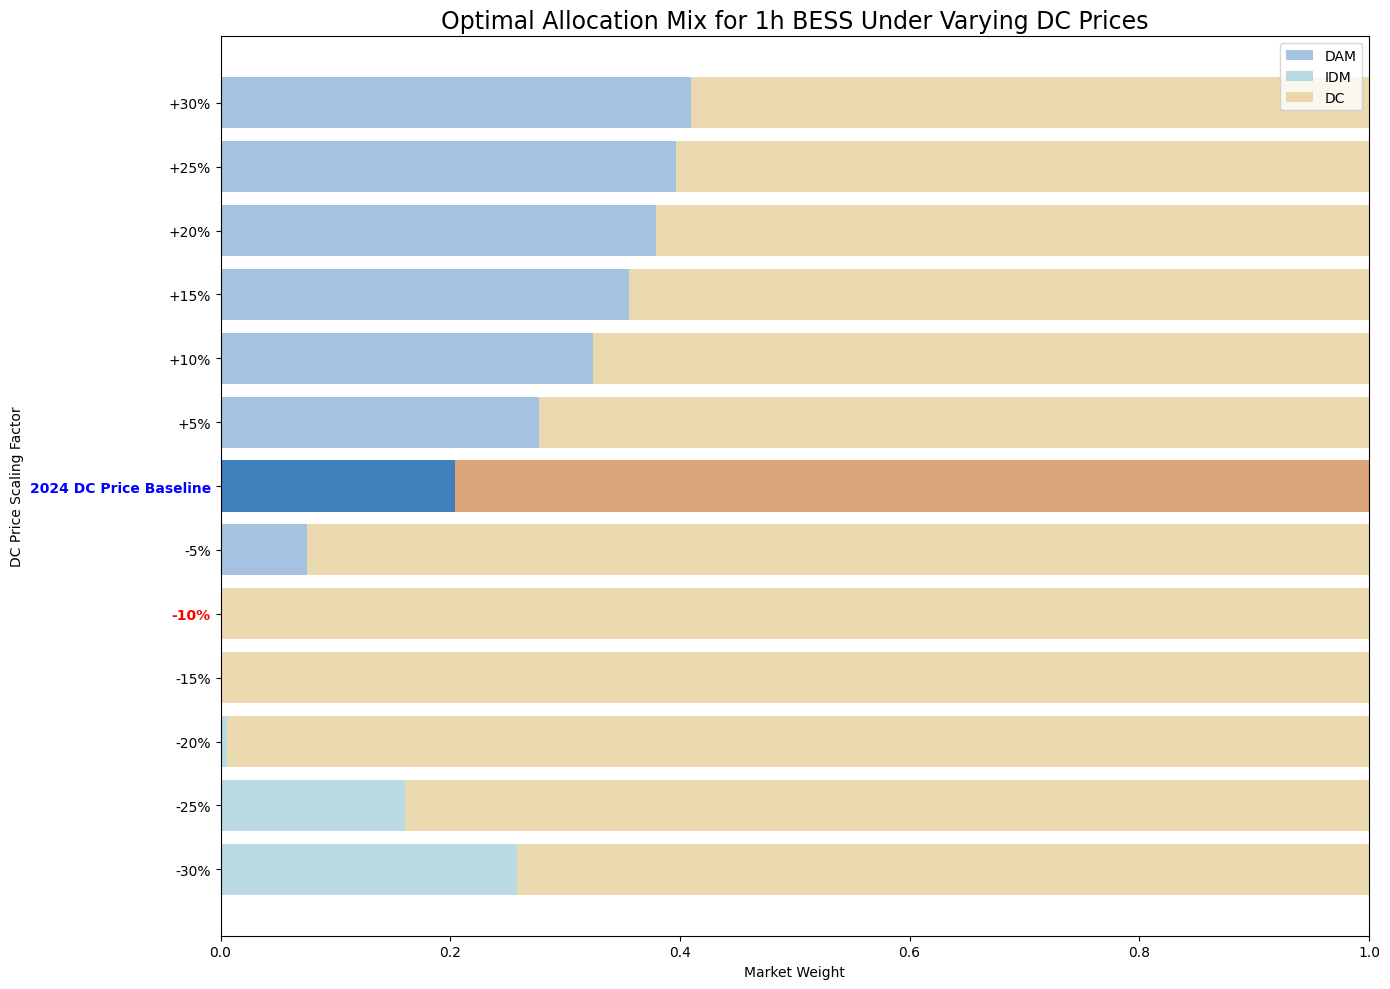

In [7]:
# 1-Hour Battery Analysis (scaling from -30% to +30%)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load 1-hour battery data
df_1h = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_13&15-18_Model Outputs/Fig_13&15-18_data.csv')
df_1h['duration'] = df_1h['energy_mwh'] / df_1h['power_mw']

# Filter for 1-hour batteries only
df_1h = df_1h[df_1h['duration'] == 1.0]

# Check if we have data for 1h batteries
if df_1h.empty:
    print("No 1h battery data found in the dataset")
else:
    print(f"Found {len(df_1h)} rows of 1h battery data")
    print("Available columns:", df_1h.columns.tolist())
    print("Sample of data:")
    print(df_1h.head())

# Get unique scenarios for 1h data
scenarios_1h = df_1h['scenario'].unique()
print("Available scenarios:", scenarios_1h)

# Create summary data for 1h battery
summary_1h = []
for scenario in scenarios_1h:
    scenario_data = df_1h[df_1h['scenario'] == scenario]
    if not scenario_data.empty:
        row = scenario_data.iloc[0]
        summary_1h.append({
            'scenario': scenario,
            'dc_price_scale': row['dc_price_scale_factor'],
            'dam_weight': row['dam_weight'],
            'idm_weight': row['idm_weight'],
            'dc_weight': row['dc_weight']
        })

summary_1h_df = pd.DataFrame(summary_1h)

# Check if we have any data
if summary_1h_df.empty:
    print("No summary data created - check data availability")
else:
    # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
    summary_1h_df = summary_1h_df[(summary_1h_df['dc_price_scale'] >= 0.7) & 
                                  (summary_1h_df['dc_price_scale'] <= 1.3)]
    
    # Create mapping from scale factor to percentage labels for 1h data (-30% to +30%)
    scale_to_label_1h = {
        0.7: '-30%', 0.75: '-25%', 0.8: '-20%', 0.85: '-15%', 
        0.9: '-10%', 0.95: '-5%',
        1.0: '2024 DC Price Baseline',
        1.05: '+5%', 1.1: '+10%', 1.15: '+15%', 1.2: '+20%', 1.25: '+25%', 1.3: '+30%'
    }
    
    # Single horizontal stacked bar chart for 1h battery
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Base colors (full saturation for base case)
    base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
    # Less saturated colors for other scenarios
    light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}
    
    # Sort by DC price scale
    subset_1h = summary_1h_df.sort_values('dc_price_scale')
    y_pos = np.arange(len(subset_1h))
    
    # Create bars with different colors based on scenario
    for i, (idx, row) in enumerate(subset_1h.iterrows()):
        scale = row['dc_price_scale']
        
        # Determine colors based on scenario
        if scale == 1.0:  # Base case
            colors = base_colors
        else:
            colors = light_colors
        
        # Horizontal stacked bars
        ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                color=colors['DAM'], alpha=0.8)
        ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
        ax.barh(i, row['dc_weight'], 
                left=row['dam_weight'] + row['idm_weight'],
                label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
    
    ax.set_ylabel('DC Price Scaling Factor')
    ax.set_xlabel('Market Weight')
    ax.set_title('Optimal Allocation Mix for 1h BESS Under Varying DC Prices', fontsize=17)
    ax.set_yticks(y_pos)
    
    # Create y-tick labels with special formatting
    y_labels = []
    for scale in subset_1h['dc_price_scale']:
        label = scale_to_label_1h[scale]
        y_labels.append(label)
    
    ax.set_yticklabels(y_labels)
    
    # Format specific labels with color and weight
    for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_1h['dc_price_scale'])):
        if scale in [0.9]:  # -10% - highlighting relevant scale for 1h
            tick.set_color('red')
            tick.set_fontweight('bold')
        elif scale == 1.0:  # Base case
            tick.set_color('blue')
            tick.set_fontweight('bold')
    
    ax.legend()
    ax.grid(False)  # Remove grid
    ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    

Found 39 rows of 1.5h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_scale_factor', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
    config_id  power_mw  energy_mwh   scenario  dc_price_scale_factor  \
52          5        10          15  base_case                   1.00   
53          5        10          15   down_30%                   0.70   
54          5        10          15   down_25%                   0.75   
55          5        10          15   down_20%                   0.80   
56          5        10          15   down_15%                   0.85   

      dam_weight  idm_weight     dc_weight  expected_return  portfolio_risk  \
52  3.069729e-16    0.284665  7.153353e-01       764.779159      528.183064   
53  8.981936e-01    0.101806  5.551115e-17       652.433095      469.943094   
54  7.971186e-01    0.202881  0.000000e+00       655.718973      481.430253   
55  3.97

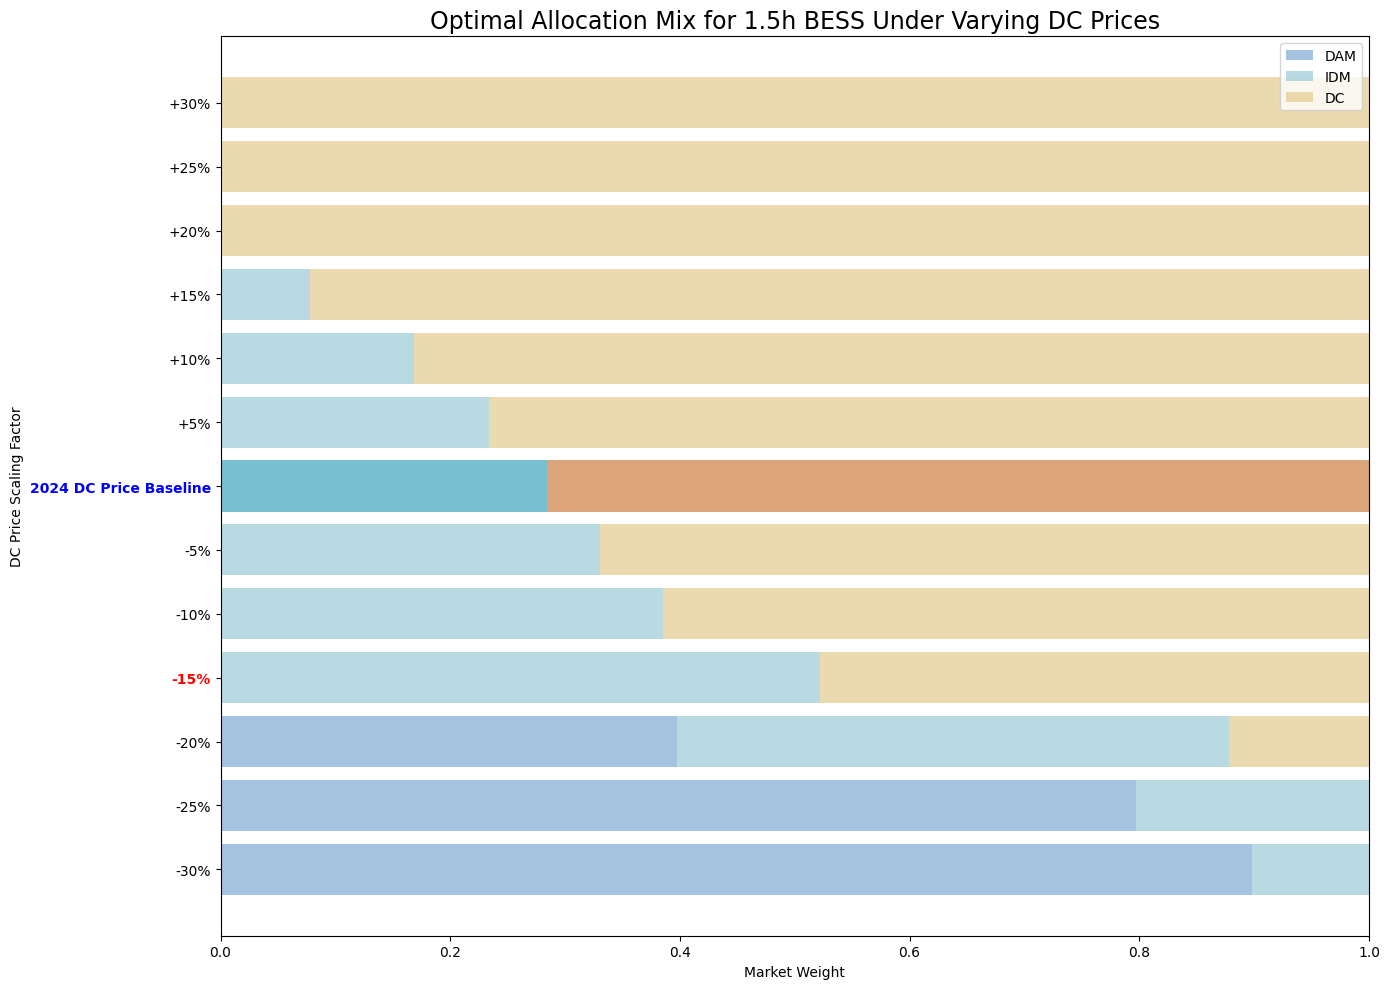

In [14]:
# 1.5-Hour Battery Analysis (scaling from -30% to +30%)

# Load 1.5-hour battery data
df_15h = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_13&15-18_Model Outputs/Fig_13,15,16_data.csv')
df_15h['duration'] = df_15h['energy_mwh'] / df_15h['power_mw']

# Filter for 1.5-hour batteries only
df_15h = df_15h[df_15h['duration'] == 1.5]

# Check if we have data for 1.5h batteries
if df_15h.empty:
    print("No 1.5h battery data found in the dataset")
else:
    print(f"Found {len(df_15h)} rows of 1.5h battery data")
    print("Available columns:", df_15h.columns.tolist())
    print("Sample of data:")
    print(df_15h.head())

# Get unique scenarios for 1.5h data
scenarios_15h = df_15h['scenario'].unique()
print("Available scenarios:", scenarios_15h)

# Create summary data for 1.5h battery
summary_15h = []
for scenario in scenarios_15h:
    scenario_data = df_15h[df_15h['scenario'] == scenario]
    if not scenario_data.empty:
        row = scenario_data.iloc[0]
        summary_15h.append({
            'scenario': scenario,
            'dc_price_scale': row['dc_price_scale_factor'],
            'dam_weight': row['dam_weight'],
            'idm_weight': row['idm_weight'],
            'dc_weight': row['dc_weight']
        })

summary_15h_df = pd.DataFrame(summary_15h)

# Check if we have any data
if summary_15h_df.empty:
    print("No summary data created - check data availability")
else:
    # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
    summary_15h_df = summary_15h_df[(summary_15h_df['dc_price_scale'] >= 0.7) & 
                                    (summary_15h_df['dc_price_scale'] <= 1.3)]
    
    # Create mapping from scale factor to percentage labels for 1.5h data (-30% to +30%)
    scale_to_label_15h = {
        0.7: '-30%', 0.75: '-25%', 0.8: '-20%', 0.85: '-15%', 
        0.9: '-10%', 0.95: '-5%',
        1.0: '2024 DC Price Baseline',
        1.05: '+5%', 1.1: '+10%', 1.15: '+15%', 1.2: '+20%', 1.25: '+25%', 1.3: '+30%'
    }
    
    # Single horizontal stacked bar chart for 1.5h battery
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Base colors (full saturation for base case)
    base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
    # Less saturated colors for other scenarios
    light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}
    
    # Sort by DC price scale
    subset_15h = summary_15h_df.sort_values('dc_price_scale')
    y_pos = np.arange(len(subset_15h))
    
    # Create bars with different colors based on scenario
    for i, (idx, row) in enumerate(subset_15h.iterrows()):
        scale = row['dc_price_scale']
        
        # Determine colors based on scenario
        if scale == 1.0:  # Base case
            colors = base_colors
        else:
            colors = light_colors
        
        # Horizontal stacked bars
        ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                color=colors['DAM'], alpha=0.8)
        ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
        ax.barh(i, row['dc_weight'], 
                left=row['dam_weight'] + row['idm_weight'],
                label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
    
    ax.set_ylabel('DC Price Scaling Factor')
    ax.set_xlabel('Market Weight')
    ax.set_title('Optimal Allocation Mix for 1.5h BESS Under Varying DC Prices', fontsize=17)
    ax.set_yticks(y_pos)
    
    # Create y-tick labels with special formatting
    y_labels = []
    for scale in subset_15h['dc_price_scale']:
        label = scale_to_label_15h[scale]
        y_labels.append(label)
    
    ax.set_yticklabels(y_labels)
    
    # Format specific labels with color and weight
    for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_15h['dc_price_scale'])):
        if scale in [0.85]:  # -15%
            tick.set_color('red')
            tick.set_fontweight('bold')
        elif scale == 1.0:  # Base case
            tick.set_color('blue')
            tick.set_fontweight('bold')
    
    ax.legend()
    ax.grid(False)  # Remove grid
    ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    

Available scenarios: ['base_case' 'down_30%' 'down_25%' 'down_20%' 'down_15%' 'down_10%'
 'down_5%' 'up_5%' 'up_10%' 'up_15%' 'up_25%' 'up_20%' 'up_30%']


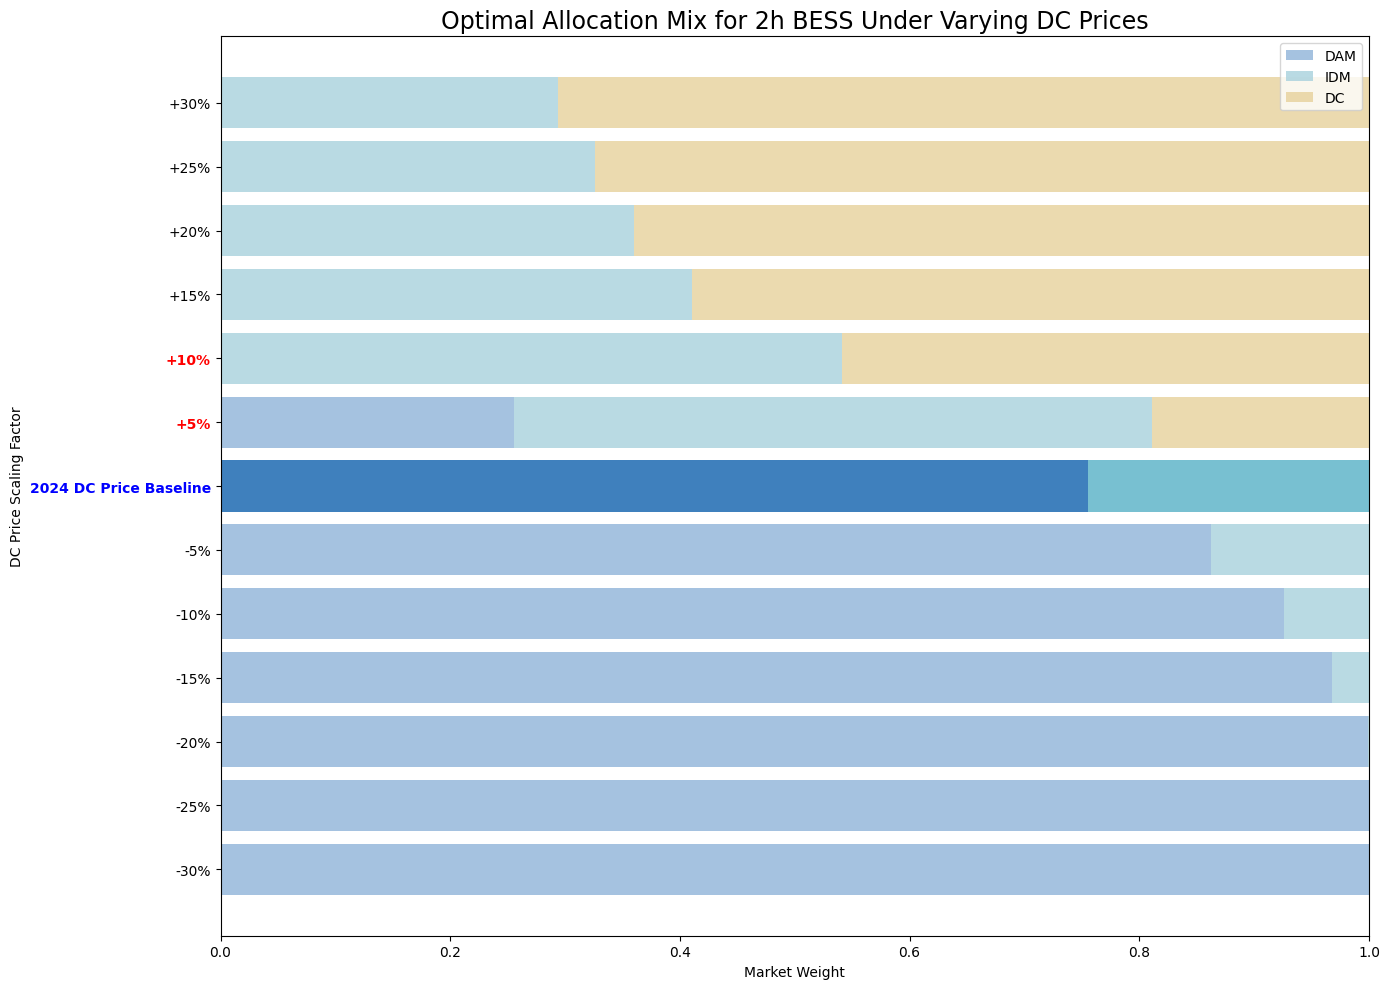

In [15]:
# 2-Hour Battery Analysis (scaling from -30% to +30%)

# Load 2-hour battery data
df_2h = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_13&15-18_Model Outputs/Fig_13,15,16_data.csv')
df_2h['duration'] = df_2h['energy_mwh'] / df_2h['power_mw']

# Filter for 2-hour batteries only
df_2h = df_2h[df_2h['duration'] == 2.0]

# Get unique scenarios for 2h data
scenarios_2h = df_2h['scenario'].unique()
print("Available scenarios:", scenarios_2h)

# Create summary data for 2h battery
summary_2h = []
for scenario in scenarios_2h:
    scenario_data = df_2h[df_2h['scenario'] == scenario]
    if not scenario_data.empty:
        row = scenario_data.iloc[0]
        summary_2h.append({
            'scenario': scenario,
            'dc_price_scale': row['dc_price_scale_factor'],
            'dam_weight': row['dam_weight'],
            'idm_weight': row['idm_weight'],
            'dc_weight': row['dc_weight']
        })

summary_2h_df = pd.DataFrame(summary_2h)

# Check if we have any data
if summary_2h_df.empty:
    print("No summary data created - check data availability")
else:
    # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
    summary_2h_df = summary_2h_df[(summary_2h_df['dc_price_scale'] >= 0.7) & 
                                    (summary_2h_df['dc_price_scale'] <= 1.3)]

    # Create mapping from scale factor to percentage labels for 2h data (-30% to +30%)
    scale_to_label_2h = {
        0.7: '-30%', 0.75: '-25%', 0.8: '-20%', 0.85: '-15%', 
        0.9: '-10%', 0.95: '-5%',
        1.0: '2024 DC Price Baseline',
        1.05: '+5%', 1.1: '+10%', 1.15: '+15%', 1.2: '+20%', 1.25: '+25%', 1.3: '+30%'
    }
    
    # Single horizontal stacked bar chart for 2h battery
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Base colors (full saturation for base case)
    base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
    # Less saturated colors for other scenarios
    light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}
    
    # Sort by DC price scale
    subset_2h = summary_2h_df.sort_values('dc_price_scale')
    y_pos = np.arange(len(subset_2h))
    
    # Create bars with different colors based on scenario
    for i, (idx, row) in enumerate(subset_2h.iterrows()):
        scale = row['dc_price_scale']
        
        # Determine colors based on scenario
        if scale == 1.0:  # Base case
            colors = base_colors
        else:
            colors = light_colors
        
        # Horizontal stacked bars
        ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                color=colors['DAM'], alpha=0.8)
        ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
        ax.barh(i, row['dc_weight'], 
                left=row['dam_weight'] + row['idm_weight'],
                label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
    
    ax.set_ylabel('DC Price Scaling Factor')
    ax.set_xlabel('Market Weight')
    ax.set_title('Optimal Allocation Mix for 2h BESS Under Varying DC Prices', fontsize=17)
    ax.set_yticks(y_pos)
    
    # Create y-tick labels with special formatting
    y_labels = []
    for scale in subset_2h['dc_price_scale']:
        label = scale_to_label_2h[scale]
        y_labels.append(label)
    
    ax.set_yticklabels(y_labels)
    
    # Format specific labels with color and weight
    for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_2h['dc_price_scale'])):
        if scale in [1.1, 1.05]:  # +10%, +5% - highlighting relevant scales for 2h
            tick.set_color('red')
            tick.set_fontweight('bold')
        elif scale == 1.0:  # Base case
            tick.set_color('blue')
            tick.set_fontweight('bold')
    
    ax.legend()
    ax.grid(False)  # Remove grid
    ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    

Available scenarios: ['base_case' 'down_30%' 'down_25%' 'down_20%' 'down_15%' 'down_10%'
 'down_5%' 'up_5%' 'up_10%' 'up_15%' 'up_25%' 'up_20%' 'up_30%' 'up_40%'
 'up_50%' 'up_60%' 'up_70%' 'up_80%' 'up_90%' 'up_100%']


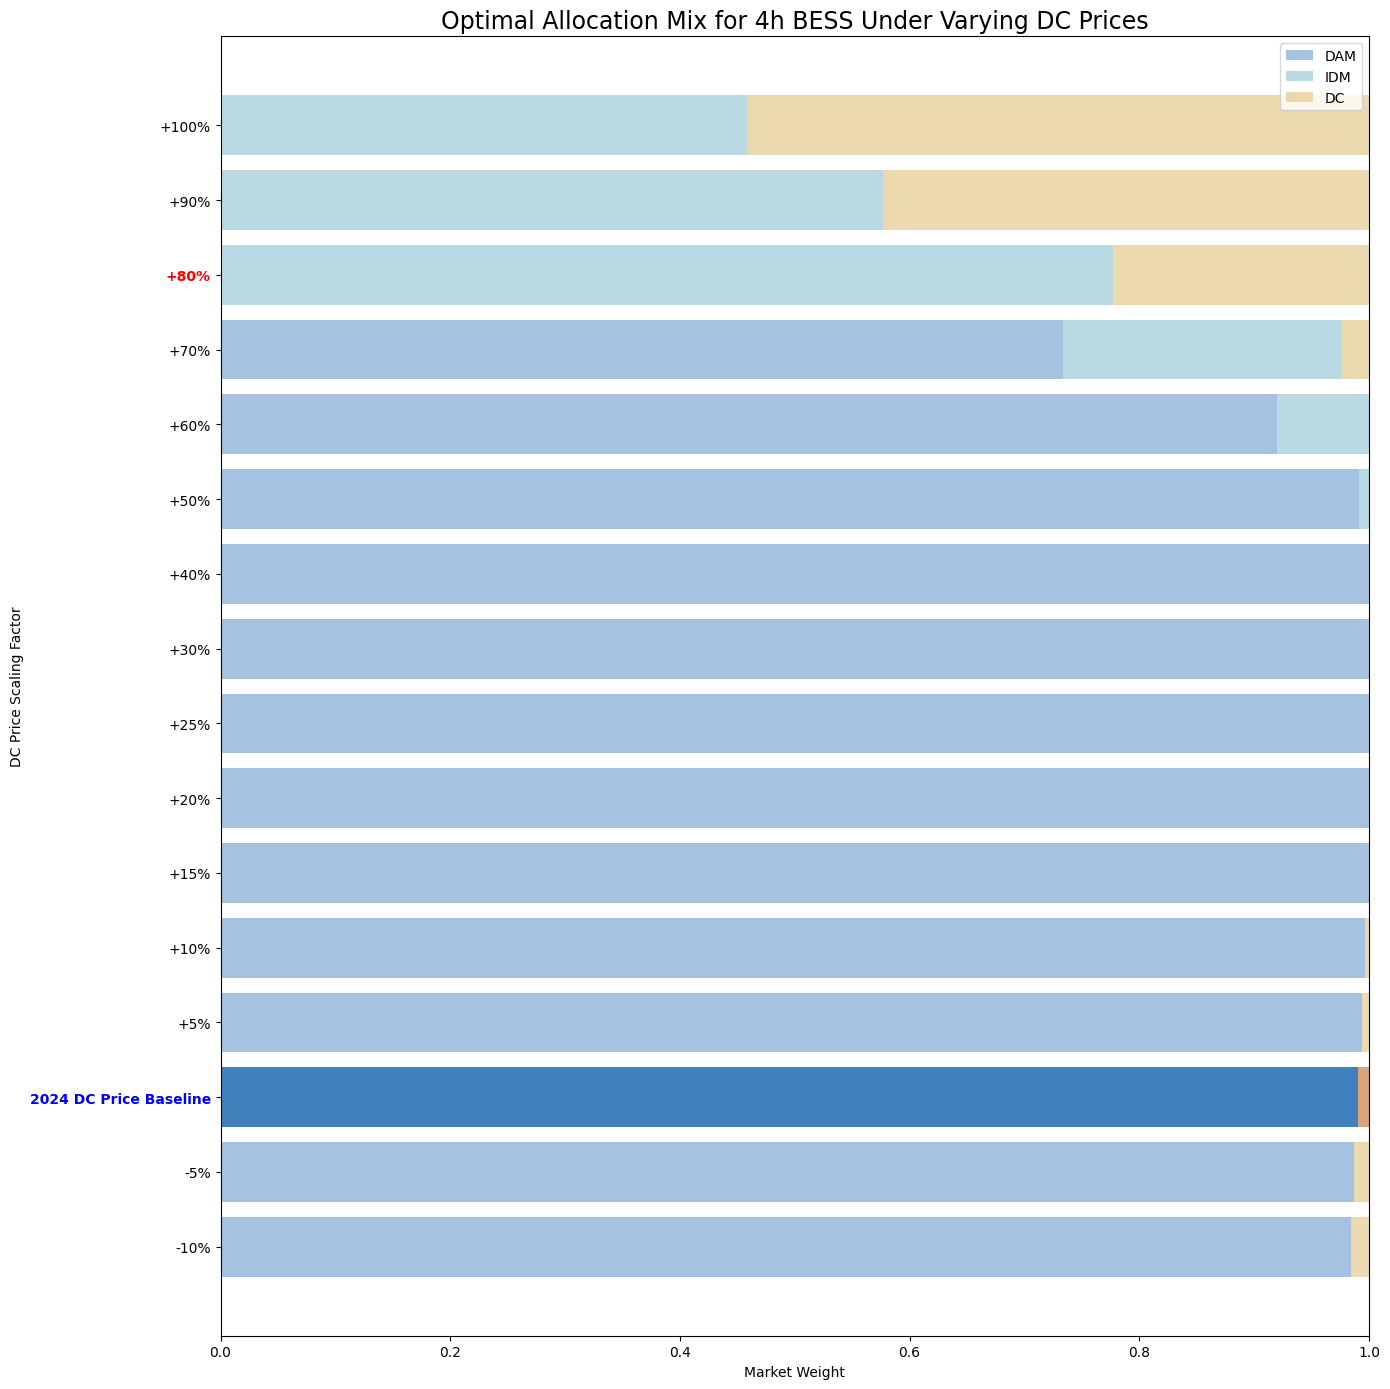

In [10]:
# 4-Hour Battery Analysis (scaling from -10% to +100%)

# Use the extended data from the 3h 4h test results file which has more scaling factors
df_4h_extended = pd.read_csv('Results for EDA/2024 D* price level 3h 4h test results.csv')
df_4h_extended['duration'] = df_4h_extended['energy_mwh'] / df_4h_extended['power_mw']

# Filter for 4-hour batteries only
df_4h_extended = df_4h_extended[df_4h_extended['duration'] == 4.0]

# Get unique scenarios for 4h data
scenarios_4h_extended = df_4h_extended['scenario'].unique()
print("Available scenarios:", scenarios_4h_extended)

# Create summary data for 4h battery
summary_4h_extended = []
for scenario in scenarios_4h_extended:
    scenario_data = df_4h_extended[df_4h_extended['scenario'] == scenario]
    if not scenario_data.empty:
        row = scenario_data.iloc[0]
        summary_4h_extended.append({
            'scenario': scenario,
            'dc_price_scale': row['dc_price_scale_factor'],
            'dam_weight': row['dam_weight'],
            'idm_weight': row['idm_weight'],
            'dc_weight': row['dc_weight']
        })

summary_4h_extended_df = pd.DataFrame(summary_4h_extended)

# Check if we have any data
if summary_4h_extended_df.empty:
    print("No summary data created - check data availability")
else:
    # Filter for scaling factors from 0.9 to 2.0 (-10% to +100%)
    summary_4h_extended_df = summary_4h_extended_df[(summary_4h_extended_df['dc_price_scale'] >= 0.9) & 
                                                    (summary_4h_extended_df['dc_price_scale'] <= 2.0)]

    # Create mapping from scale factor to percentage labels for 4h data (-10% to +100%)
    scale_to_label_4h_extended = {
        0.9: '-10%', 0.95: '-5%',
        1.0: '2024 DC Price Baseline',
        1.05: '+5%', 1.1: '+10%', 1.15: '+15%', 1.2: '+20%', 1.25: '+25%', 1.3: '+30%',
        1.4: '+40%', 1.5: '+50%', 1.6: '+60%', 1.7: '+70%', 1.8: '+80%', 1.9: '+90%', 2.0: '+100%'
    }
    
    # Single horizontal stacked bar chart for 4h battery (extended range)
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))  # Taller figure for more data points
    
    # Base colors (full saturation for base case)
    base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
    # Less saturated colors for other scenarios
    light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}
    
    # Sort by DC price scale
    subset_4h_extended = summary_4h_extended_df.sort_values('dc_price_scale')
    y_pos = np.arange(len(subset_4h_extended))
    
    # Create bars with different colors based on scenario
    for i, (idx, row) in enumerate(subset_4h_extended.iterrows()):
        scale = row['dc_price_scale']
        
        # Determine colors based on scenario
        if scale == 1.0:  # Base case
            colors = base_colors
        else:
            colors = light_colors
        
        # Horizontal stacked bars
        ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                color=colors['DAM'], alpha=0.8)
        ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
        ax.barh(i, row['dc_weight'], 
                left=row['dam_weight'] + row['idm_weight'],
                label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
    
    ax.set_ylabel('DC Price Scaling Factor')
    ax.set_xlabel('Market Weight')
    ax.set_title('Optimal Allocation Mix for 4h BESS Under Varying DC Prices', fontsize=17)
    ax.set_yticks(y_pos)
    
    # Create y-tick labels with special formatting
    y_labels = []
    for scale in subset_4h_extended['dc_price_scale']:
        label = scale_to_label_4h_extended[scale]
        y_labels.append(label)
    
    ax.set_yticklabels(y_labels)
    
    # Format specific labels with color and weight
    for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_4h_extended['dc_price_scale'])):
        if scale in [1.8]:  # +50%, +60% - highlighting high scaling factors
            tick.set_color('red')
            tick.set_fontweight('bold')
        elif scale == 1.0:  # Base case
            tick.set_color('blue')
            tick.set_fontweight('bold')
    
    ax.legend()
    ax.grid(False)  # Remove grid
    ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    

Available scenarios: ['base_case' 'down_10%' 'down_5%' 'up_5%' 'up_10%' 'up_15%' 'up_25%'
 'up_20%' 'up_30%' 'up_40%' 'up_50%' 'up_60%' 'up_70%' 'up_80%' 'up_90%'
 'up_100%']


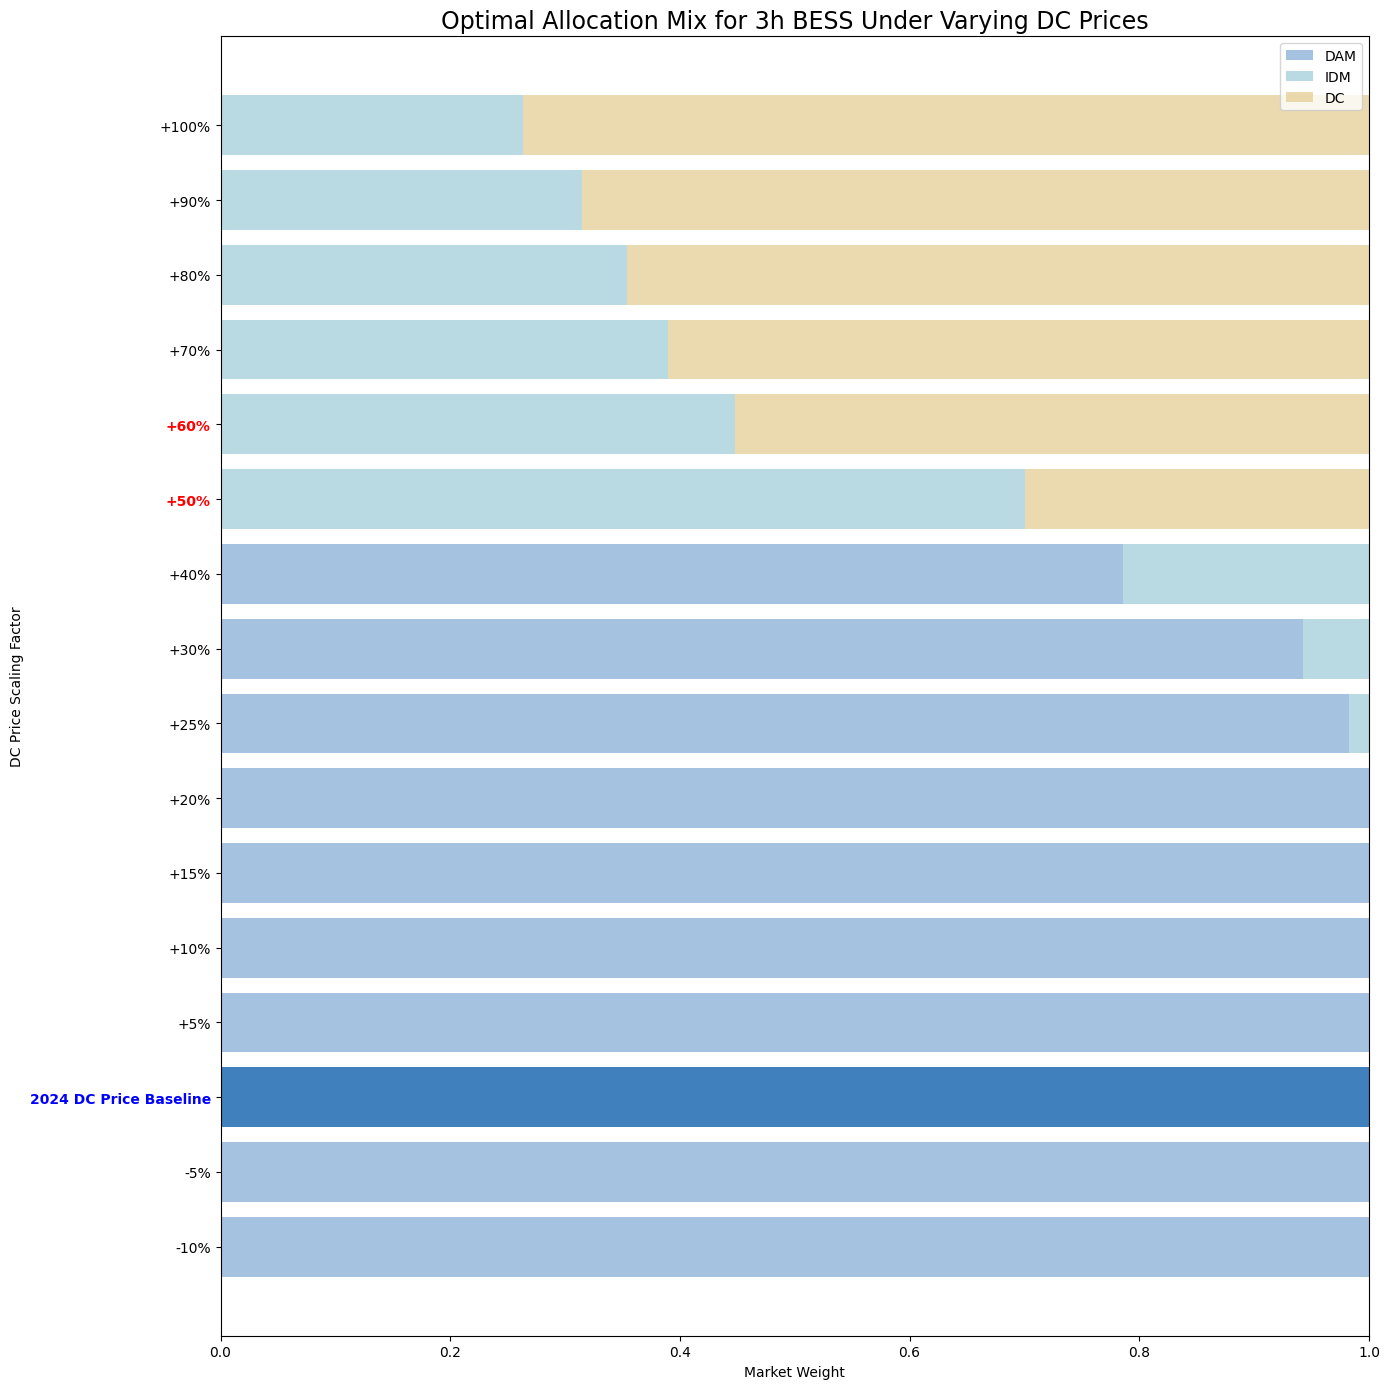

In [16]:
# 3-Hour Battery Analysis (scaling from -10% to +100%)

# Use the extended data from the 3h 4h test results file which has more scaling factors
df_3h_extended = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_13&15-18_Model Outputs/Fig_17&18_data.csv')
df_3h_extended['duration'] = df_3h_extended['energy_mwh'] / df_3h_extended['power_mw']

# Filter for 3-hour batteries only
df_3h_extended = df_3h_extended[df_3h_extended['duration'] == 3.0]

# Get unique scenarios for 3h data
scenarios_3h_extended = df_3h_extended['scenario'].unique()
print("Available scenarios:", scenarios_3h_extended)

# Create summary data for 3h battery
summary_3h_extended = []
for scenario in scenarios_3h_extended:
    scenario_data = df_3h_extended[df_3h_extended['scenario'] == scenario]
    if not scenario_data.empty:
        row = scenario_data.iloc[0]
        summary_3h_extended.append({
            'scenario': scenario,
            'dc_price_scale': row['dc_price_scale_factor'],
            'dam_weight': row['dam_weight'],
            'idm_weight': row['idm_weight'],
            'dc_weight': row['dc_weight']
        })

summary_3h_extended_df = pd.DataFrame(summary_3h_extended)

# Check if we have any data
if summary_3h_extended_df.empty:
    print("No summary data created - check data availability")
else:
    # Filter for scaling factors from 0.9 to 2.0 (-10% to +100%)
    summary_3h_extended_df = summary_3h_extended_df[(summary_3h_extended_df['dc_price_scale'] >= 0.9) & 
                                                    (summary_3h_extended_df['dc_price_scale'] <= 2.0)]

    # Create mapping from scale factor to percentage labels for 3h data (-10% to +100%)
    scale_to_label_3h_extended = {
        0.9: '-10%', 0.95: '-5%',
        1.0: '2024 DC Price Baseline',
        1.05: '+5%', 1.1: '+10%', 1.15: '+15%', 1.2: '+20%', 1.25: '+25%', 1.3: '+30%',
        1.4: '+40%', 1.5: '+50%', 1.6: '+60%', 1.7: '+70%', 1.8: '+80%', 1.9: '+90%', 2.0: '+100%'
    }
    
    # Single horizontal stacked bar chart for 3h battery (extended range)
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))  # Taller figure for more data points
    
    # Base colors (full saturation for base case)
    base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
    # Less saturated colors for other scenarios
    light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}
    
    # Sort by DC price scale
    subset_3h_extended = summary_3h_extended_df.sort_values('dc_price_scale')
    y_pos = np.arange(len(subset_3h_extended))
    
    # Create bars with different colors based on scenario
    for i, (idx, row) in enumerate(subset_3h_extended.iterrows()):
        scale = row['dc_price_scale']
        
        # Determine colors based on scenario
        if scale == 1.0:  # Base case
            colors = base_colors
        else:
            colors = light_colors
        
        # Horizontal stacked bars
        ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                color=colors['DAM'], alpha=0.8)
        ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
        ax.barh(i, row['dc_weight'], 
                left=row['dam_weight'] + row['idm_weight'],
                label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
    
    ax.set_ylabel('DC Price Scaling Factor')
    ax.set_xlabel('Market Weight')
    ax.set_title('Optimal Allocation Mix for 3h BESS Under Varying DC Prices', fontsize=17)
    ax.set_yticks(y_pos)
    
    # Create y-tick labels with special formatting
    y_labels = []
    for scale in subset_3h_extended['dc_price_scale']:
        label = scale_to_label_3h_extended[scale]
        y_labels.append(label)
    
    ax.set_yticklabels(y_labels)
    
    # Format specific labels with color and weight
    for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_3h_extended['dc_price_scale'])):
        if scale in [1.5, 1.6]:  # +50%, +60% - highlighting high scaling factors
            tick.set_color('red')
            tick.set_fontweight('bold')
        elif scale == 1.0:  # Base case
            tick.set_color('blue')
            tick.set_fontweight('bold')
    
    ax.legend()
    ax.grid(False)  # Remove grid
    ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    

Available scenarios: ['base_case' 'down_10%' 'down_5%' 'up_5%' 'up_10%' 'up_15%' 'up_25%'
 'up_20%' 'up_30%' 'up_40%' 'up_50%' 'up_60%' 'up_70%' 'up_80%' 'up_90%'
 'up_100%']


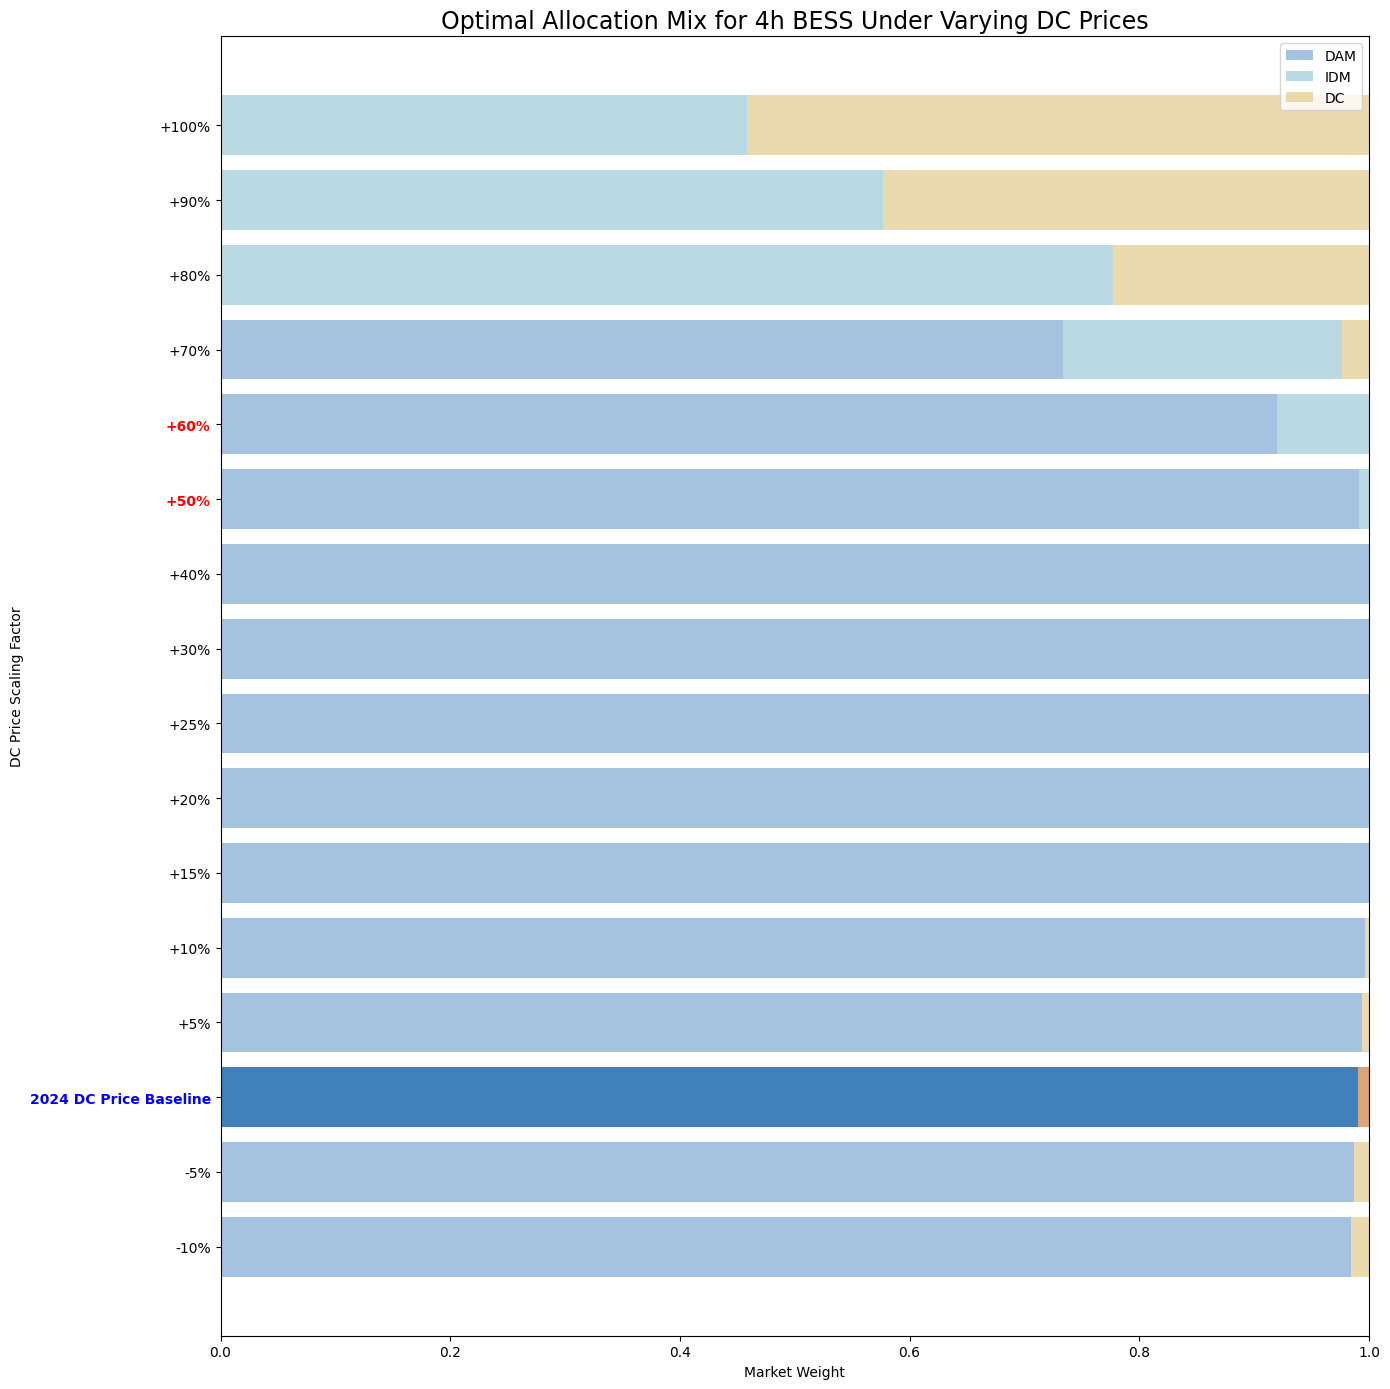

In [18]:
# 4-Hour Battery Analysis (scaling from -10% to +100%)

# Use the extended data from the 3h 4h test results file which has more scaling factors
df_4h_extended = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_13&15-18_Model Outputs/Fig_17&18_data.csv')
df_4h_extended['duration'] = df_4h_extended['energy_mwh'] / df_4h_extended['power_mw']

# Filter for 4-hour batteries only
df_4h_extended = df_4h_extended[df_4h_extended['duration'] == 4.0]

# Get unique scenarios for 4h data
scenarios_4h_extended = df_4h_extended['scenario'].unique()
print("Available scenarios:", scenarios_4h_extended)

# Create summary data for 4h battery
summary_4h_extended = []
for scenario in scenarios_4h_extended:
    scenario_data = df_4h_extended[df_4h_extended['scenario'] == scenario]
    if not scenario_data.empty:
        row = scenario_data.iloc[0]
        summary_4h_extended.append({
            'scenario': scenario,
            'dc_price_scale': row['dc_price_scale_factor'],
            'dam_weight': row['dam_weight'],
            'idm_weight': row['idm_weight'],
            'dc_weight': row['dc_weight']
        })

summary_4h_extended_df = pd.DataFrame(summary_4h_extended)

# Check if we have any data
if summary_4h_extended_df.empty:
    print("No summary data created - check data availability")
else:
    # Filter for scaling factors from 0.9 to 2.0 (-10% to +100%)
    summary_4h_extended_df = summary_4h_extended_df[(summary_4h_extended_df['dc_price_scale'] >= 0.9) & 
                                                    (summary_4h_extended_df['dc_price_scale'] <= 2.0)]

    # Create mapping from scale factor to percentage labels for 4h data (-10% to +100%)
    scale_to_label_4h_extended = {
        0.9: '-10%', 0.95: '-5%',
        1.0: '2024 DC Price Baseline',
        1.05: '+5%', 1.1: '+10%', 1.15: '+15%', 1.2: '+20%', 1.25: '+25%', 1.3: '+30%',
        1.4: '+40%', 1.5: '+50%', 1.6: '+60%', 1.7: '+70%', 1.8: '+80%', 1.9: '+90%', 2.0: '+100%'
    }

    # Single horizontal stacked bar chart for 4h battery (extended range)
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))  # Taller figure for more data points
    
    # Base colors (full saturation for base case)
    base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
    # Less saturated colors for other scenarios
    light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}
    
    # Sort by DC price scale
    subset_4h_extended = summary_4h_extended_df.sort_values('dc_price_scale')
    y_pos = np.arange(len(subset_4h_extended))

    # Create bars with different colors based on scenario
    for i, (idx, row) in enumerate(subset_4h_extended.iterrows()):
        scale = row['dc_price_scale']
        
        # Determine colors based on scenario
        if scale == 1.0:  # Base case
            colors = base_colors
        else:
            colors = light_colors
        
        # Horizontal stacked bars
        ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                color=colors['DAM'], alpha=0.8)
        ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
        ax.barh(i, row['dc_weight'], 
                left=row['dam_weight'] + row['idm_weight'],
                label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
    
    ax.set_ylabel('DC Price Scaling Factor')
    ax.set_xlabel('Market Weight')
    ax.set_title('Optimal Allocation Mix for 4h BESS Under Varying DC Prices', fontsize=17)
    ax.set_yticks(y_pos)
    
    # Create y-tick labels with special formatting
    y_labels = []
    for scale in subset_4h_extended['dc_price_scale']:
        label = scale_to_label_4h_extended[scale]
        y_labels.append(label)
    
    ax.set_yticklabels(y_labels)
    
    # Format specific labels with color and weight
    for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_4h_extended['dc_price_scale'])):
        if scale in [1.5, 1.6]:  # +50%, +60% - highlighting high scaling factors
            tick.set_color('red')
            tick.set_fontweight('bold')
        elif scale == 1.0:  # Base case
            tick.set_color('blue')
            tick.set_fontweight('bold')
    
    ax.legend()
    ax.grid(False)  # Remove grid
    ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    